In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import zscore
from scipy.signal import detrend
from scipy.ndimage import gaussian_filter1d
import time
import gc
import copy

def smooth_with_gaussian(data, sigma=3):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 

file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]
structure = {f'dataset_{file_number}': {
    'left_attleft': [],
    'right_attleft': [],
    'left_attright': [],
    'right_attright': []
} for file_number in file_numbers}

# def preprocess(data):
#     data = detrend(data, axis=0)
#     epsilon = 1e-9
#     data = (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + epsilon)
    
#     return data

def preprocess(data):
    stds = np.std(data[:, :], axis=0)
    non_constant_cols = stds > 1e-6
    if len(non_constant_cols) != 0:
        print('non constant column at ', np.where(non_constant_cols == False))
                

    constant_cols = stds < 1e-6

    z = np.zeros_like(data[:, :])
    z[:, non_constant_cols] = zscore(data[:, non_constant_cols], axis=0)
    z[:, constant_cols] = np.mean(data[:, constant_cols], axis = 0)

    #unsure what to replace lost values with, for now replacing with 0

    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z

def mean_std_store(data, key):
    mean = np.mean(data)
    std = np.std(data)
    sem = std / np.sqrt(len(data))
    pearson_results[f'dataset_{file_number}'][key] = mean
    pearson_errors[f'dataset_{file_number}'][key] = sem

pearson_results = copy.deepcopy(structure)
pearson_errors = copy.deepcopy(structure)


total_time = time.time()
for file_number in  file_numbers:
    file_total = time.time()
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]
    relevant = np.where(omitted ==0)[0]
    # left_input_SP (2032, 500, 160)
    # right_input_SP (2032, 500, 160)
    # attention_SP (2032, 500, 80)

    left_input_SP = data['SP'][0][0][relevant]
    right_input_SP = data['SP'][0][1][relevant]
    attention_SP = data['SP'][0][2][relevant]

    print(left_input_SP.shape, right_input_SP.shape, attention_SP.shape)
    
    #add in here at some point left != right and see if it makes a difference
    left_indices_agg = np.where((omitted ==0) & (attend_01 == 0))[0]  #indices of agg where left
    _, left_indices, _ = np.intersect1d(relevant, left_indices_agg, return_indices = True)   #indices for relevant processed data where attention left
    right_indices_agg = np.where((omitted ==0) & (attend_01 == 1))[0]
    _, right_indices, _ = np.intersect1d(relevant, right_indices_agg, return_indices = True)

    print(left_indices.shape, right_indices.shape)

    sigma = 2

    left_sm = smooth_with_gaussian(left_input_SP, sigma=sigma) 
    right_sm = smooth_with_gaussian(right_input_SP, sigma=sigma) 
    att_sm = smooth_with_gaussian(attention_SP, sigma=sigma) 

    num_trials, num_samples, num_neurons = left_input_SP.shape
    num_neurons_attention = 80

    for j in range(0, num_trials):
        for i in range(0, num_neurons):
            count_left = np.count_nonzero(left_input_SP[j, :, i] == 1)
            if count_left > 0:
                left_sm[j, :, i] /= count_left
            count_right = np.count_nonzero(right_input_SP[j, :, i] == 1)
            if count_right > 0:
                right_sm[j, :, i] /= count_right


        for i in range(0, num_neurons_attention):
            count_attention = np.count_nonzero(attention_SP[j, :, i] == 1)
            if count_attention > 0:
                att_sm[j, :, i] /= count_attention


    left_input_SP = np.sum(left_sm, axis=2)
    right_input_SP = np.sum(right_sm, axis=2)
    attention_SP = np.sum(att_sm, axis=2)

    #preprocess here now that we have traces of all of the relavant trials
    left_input_SP = preprocess(left_input_SP)
    right_input_SP = preprocess(right_input_SP)
    attention_SP = preprocess(attention_SP)

    #splitting left and right
    left_input_SP_attleft = left_input_SP[left_indices, 100:350]
    right_input_SP_attleft = right_input_SP[left_indices, 100:350]
    attention_SP_attleft = attention_SP[left_indices, 100:350]

    print(left_input_SP_attleft.shape, right_input_SP_attleft.shape, attention_SP_attleft.shape)

    left_input_SP_attright = left_input_SP[right_indices, 100:350]
    right_input_SP_attright = right_input_SP[right_indices, 100:350]
    attention_SP_attright = attention_SP[right_indices, 100:350]


    #----------------no preprocessing--------------------------------
    left_attleft_pearson = []
    right_attleft_pearson = []
    left_attright_pearson = []
    right_attright_pearson = []

    for i in range(len(left_input_SP_attleft)):
        left_attleft_pearson.append(pearsonr(left_input_SP_attleft[i], attention_SP_attleft[i])[0])
        right_attleft_pearson.append(pearsonr(right_input_SP_attleft[i], attention_SP_attleft[i])[0])

    for i in range(len(left_input_SP_attright)):
        left_attright_pearson.append(pearsonr(left_input_SP_attright[i], attention_SP_attright[i])[0])
        right_attright_pearson.append(pearsonr(right_input_SP_attright[i], attention_SP_attright[i])[0])
    
    mean_std_store(left_attleft_pearson, 'left_attleft')
    mean_std_store(right_attleft_pearson, 'right_attleft')
    mean_std_store(left_attright_pearson, 'left_attright')
    mean_std_store(right_attright_pearson, 'right_attright')


    del left_input_SP_attleft, right_input_SP_attleft, attention_SP_attleft, left_input_SP_attright, right_input_SP_attright, attention_SP_attright
    gc.collect()
    del(data)
    gc.collect()
    print(f'Dataset {file_number} complete in', time.time() - file_total)

print('total time elapsed =', time.time() - total_time)
print(pearson_results)


Dataset 1 loaded in 9.75 seconds
(1057, 500, 160) (1057, 500, 160) (1057, 500, 80)
(495,) (562,)
(495, 250) (495, 250) (495, 250)
Dataset 1 complete in 27.17118191719055
Dataset 2 loaded in 18.09 seconds
(990, 500, 160) (990, 500, 160) (990, 500, 80)
(488,) (502,)
(488, 250) (488, 250) (488, 250)
Dataset 2 complete in 28.87015676498413
Dataset 4 loaded in 17.21 seconds
(972, 500, 160) (972, 500, 160) (972, 500, 80)
(496,) (476,)
(496, 250) (496, 250) (496, 250)
Dataset 4 complete in 28.50858449935913
Dataset 8 loaded in 14.36 seconds
(1018, 500, 160) (1018, 500, 160) (1018, 500, 80)
(521,) (497,)
(521, 250) (521, 250) (521, 250)
Dataset 8 complete in 28.479047536849976
Dataset 14 loaded in 9.82 seconds
(1021, 500, 160) (1021, 500, 160) (1021, 500, 80)
(529,) (492,)
(529, 250) (529, 250) (529, 250)
Dataset 14 complete in 24.284204721450806
Dataset 15 loaded in 12.18 seconds
(1027, 500, 160) (1027, 500, 160) (1027, 500, 80)
(474,) (553,)
(474, 250) (474, 250) (474, 250)
Dataset 15 comple

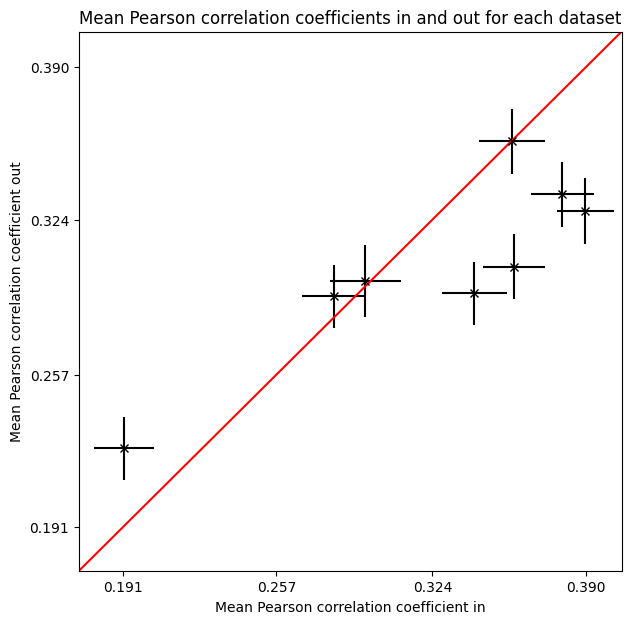

In [21]:

#want a single plot, where for each dataset, mean pearson in and mean pearson out are plotted with error bars
pearson_in = []
pearson_out = []
errors_in = []
errors_out = []

for file_number in file_numbers:
    values = []
    errors = []
    for condition in ['left_attleft', 'right_attright']:
        values.append(pearson_results[f'dataset_{file_number}'][condition])
        errors.append(pearson_errors[f'dataset_{file_number}'][condition])
    pearson_in.append(np.mean(values))
    errors_in.append(np.mean(errors))


    values = []
    errors = []
    for condition in ['left_attright', 'right_attleft']:
        values.append(pearson_results[f'dataset_{file_number}'][condition])
        errors.append(pearson_errors[f'dataset_{file_number}'][condition])
    pearson_out.append(np.mean(values))
    errors_out.append(np.mean(errors))

all_data = []
for i in range(len(pearson_in)):
    all_data.append(pearson_in[i])
    all_data.append(pearson_out[i])
min_value = np.min(all_data)
max_value = np.max(all_data)

plt.figure(figsize=(7,7))
plt.errorbar(pearson_in, pearson_out, xerr=errors_in, yerr=errors_out, fmt='x', color = 'k')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color = 'r')
plt.xlim(min_value*(0.9), max_value*(1.04))
plt.ylim(min_value*(0.9), max_value*(1.04))
plt.xticks(np.round(np.linspace(min_value, max_value, 4), 3))
plt.yticks(np.round(np.linspace(min_value, max_value, 4), 3))
plt.xlabel('Mean Pearson correlation coefficient in')
plt.ylabel('Mean Pearson correlation coefficient out')
plt.title('Mean Pearson correlation coefficients in and out for each dataset')
plt.show()

